In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os

# Check for the existence of the '../input' directory and the current directory
if os.path.exists('../input'):
    PATH = "../input"
elif os.path.exists('.'):
    PATH = "."
else:
    # Handle the case where neither path exists (e.g., raise an error or set a default)
    raise FileNotFoundError("Neither '../input' nor the current directory exists.")

print(os.listdir(PATH))

['.config', 'sample_data']


In [ ]:
data_df = pd.read_csv(PATH+"/creditcard.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.3 MB/s eta 0:00:00


In [ ]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])


Credit Card Fraud Detection data -  rows: 77338  columns: 31


In [ ]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,77338.000000,77338.000000,77338.000000,77338.000000,77338.000000,77338.000000,77338.000000,77338.000000,77338.000000,77338.000000,77338.000000,77338.000000,77338.000000,77338.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000,77337.000000
mean,36633.048243,-0.254918,-0.031977,0.678014,0.164544,-0.275915,0.096378,-0.114258,0.054293,-0.002388,-0.034845,0.288398,-0.145710,0.053769,0.091478,0.165612,-0.007117,0.075854,-0.095530,-0.022283,0.043044,-0.028664,-0.105409,-0.038736,0.007140,0.134606,0.025669,0.002190,0.002952,97.617764,0.002431
std,14986.790777,1.883504,1.670498,1.395670,1.369866,1.384600,1.304456,1.250692,1.231153,1.147883,1.079646,1.083092,1.192188,1.066218,1.015543,0.935632,0.917749,0.998366,0.857536,0.819446,0.763914,0.737389,0.636245,0.624142,0.596273,0.439940,0.498373,0.388189,0.326392,270.498883,0.049245
min,0.000000,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,-18.271168,-4.049895,-17.769143,-5.791881,-19.214325,-4.152532,-13.563273,-25.162799,-9.498746,-7.213527,-19.902611,-34.830382,-10.933144,-26.751119,-2.836627,-7.495741,-2.534330,-9.390980,-9.617915,0.000000,0.000000
25%,30195.250000,-1.016589,-0.597243,0.187865,-0.726170,-0.893539,-0.641995,-0.604823,-0.141463,-0.681631,-0.506893,-0.498668,-0.591438,-0.653520,-0.323759,-0.388170,-0.486335,-0.389745,-0.570809,-0.517886,-0.168906,-0.224615,-0.523942,-0.178388,-0.323839,-0.128938,-0.327346,-0.063209,-0.005750,7.680000,0.000000
50%,39488.000000,-0.248318,0.070092,0.765732,0.183869,-0.308220,-0.153551,-0.074168,0.068582,-0.084259,-0.095908,0.225582,0.073926,0.024766,0.096036,0.270162,0.063725,0.017576,-0.085602,-0.026835,-0.024710,-0.058979,-0.079854,-0.050419,0.063800,0.172985,-0.073324,0.009347,0.022845,26.750000,0.000000
75%,48186.000000,1.153837,0.723977,1.396222,1.046651,0.261079,0.490920,0.417033,0.347917,0.634360,0.439542,1.097425,0.603123,0.744608,0.532547,0.840181,0.546716,0.485341,0.395512,0.484075,0.170670,0.117070,0.309331,0.080314,0.404907,0.421716,0.306762,0.082399,0.076002,89.000000,0.000000
max,57006.000000,1.960497,18.902453,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,13.198226,12.018913,7.848392,4.465413,10.526766,5.784514,6.098529,9.253526,5.041069,5.228342,39.420904,22.614889,10.503090,17.297845,4.014444,5.525093,3.517346,12.152401,33.847808,19656.530000,1.000000


In [ ]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()


,V14,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V16,V15,Amount,Class,V13,V12,V8,V9,V11,V10,V2,V5,V4,V3,Time,V1,V7,V6
Total,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.001293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


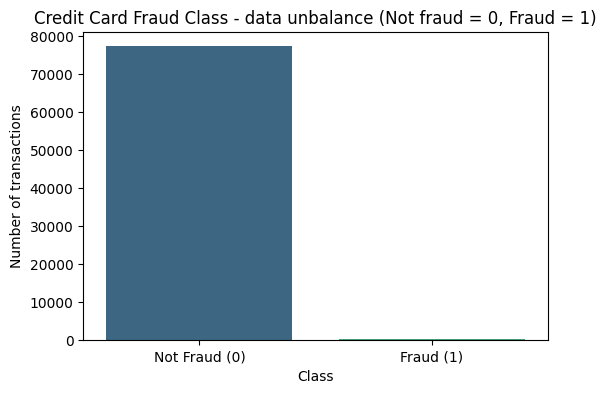

In [ ]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="yellow"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True),
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)

plt.figure(figsize=(6,4))
sns.barplot(x='Class', y='values', data=df, palette='viridis', hue='Class', legend=False)
plt.title('Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)')
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.xticks(ticks=[0, 1], labels=['Not Fraud (0)', 'Fraud (1)'])
plt.show()

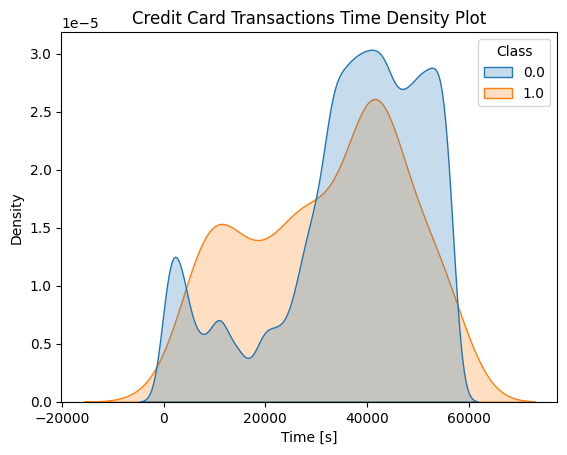

In [ ]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']




sns.kdeplot(data=data_df, x="Time", hue="Class", fill=True, common_norm=False)
plt.title('Credit Card Transactions Time Density Plot')
plt.xlabel('Time [s]')
plt.ylabel('Density')
plt.show()

In [ ]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0.0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1.0,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0.0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1.0,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0.0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


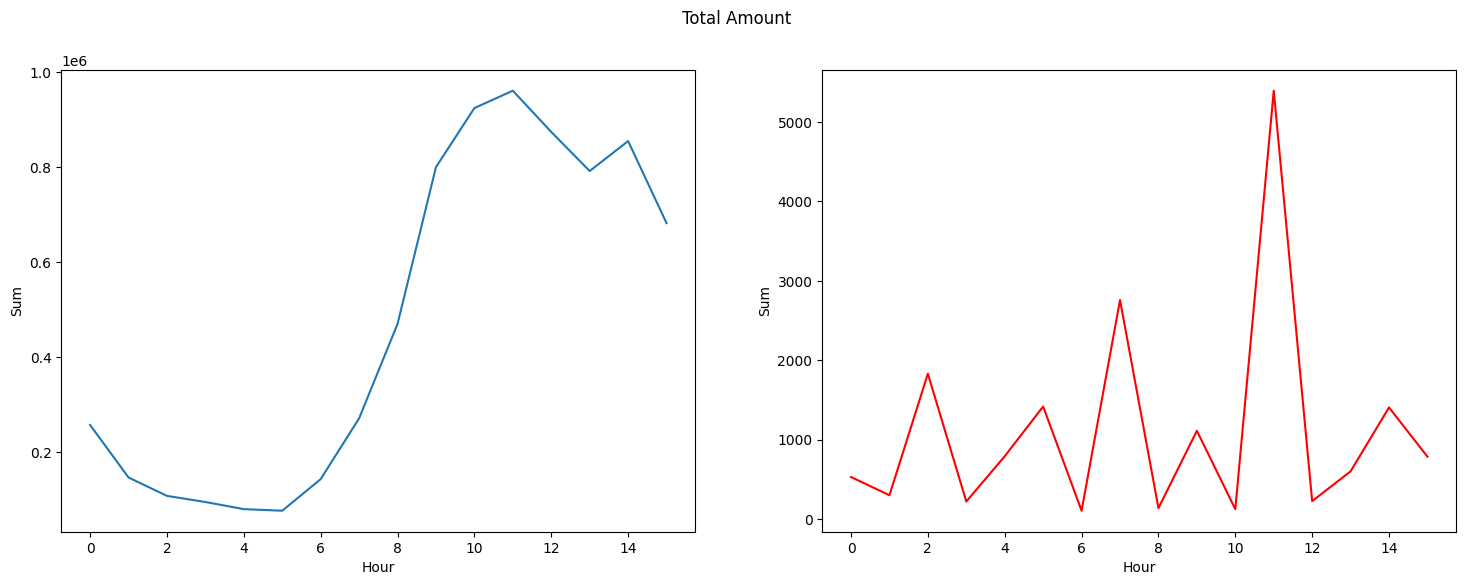

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

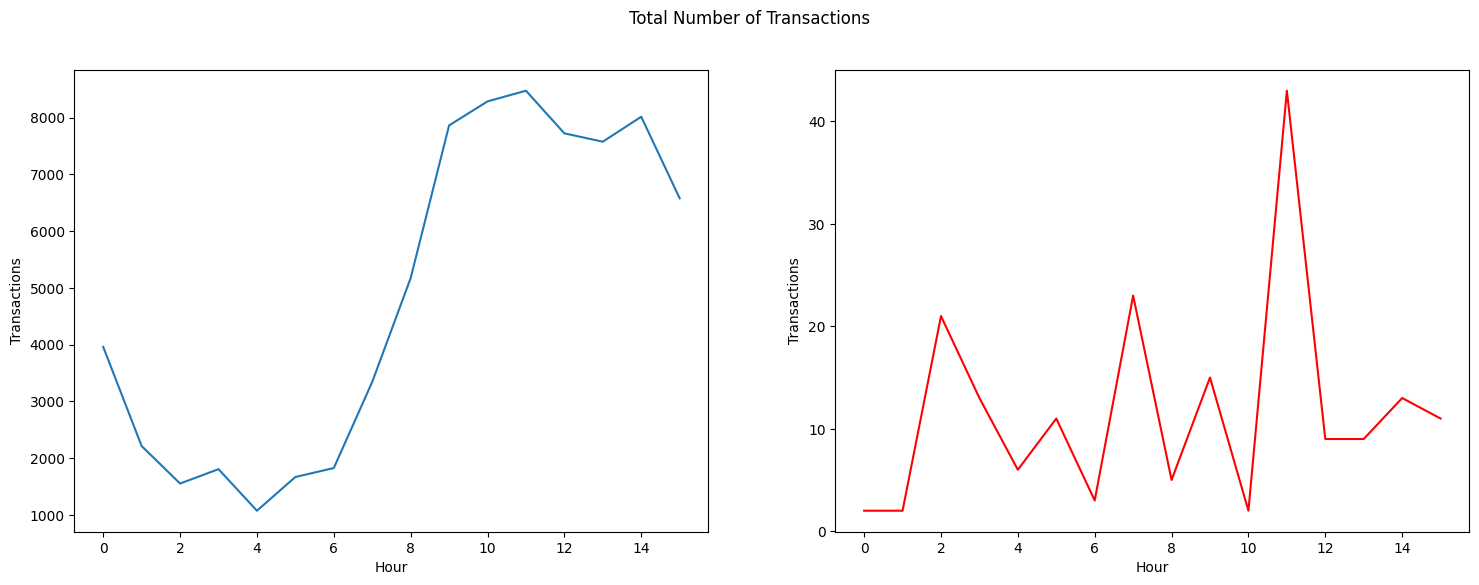

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

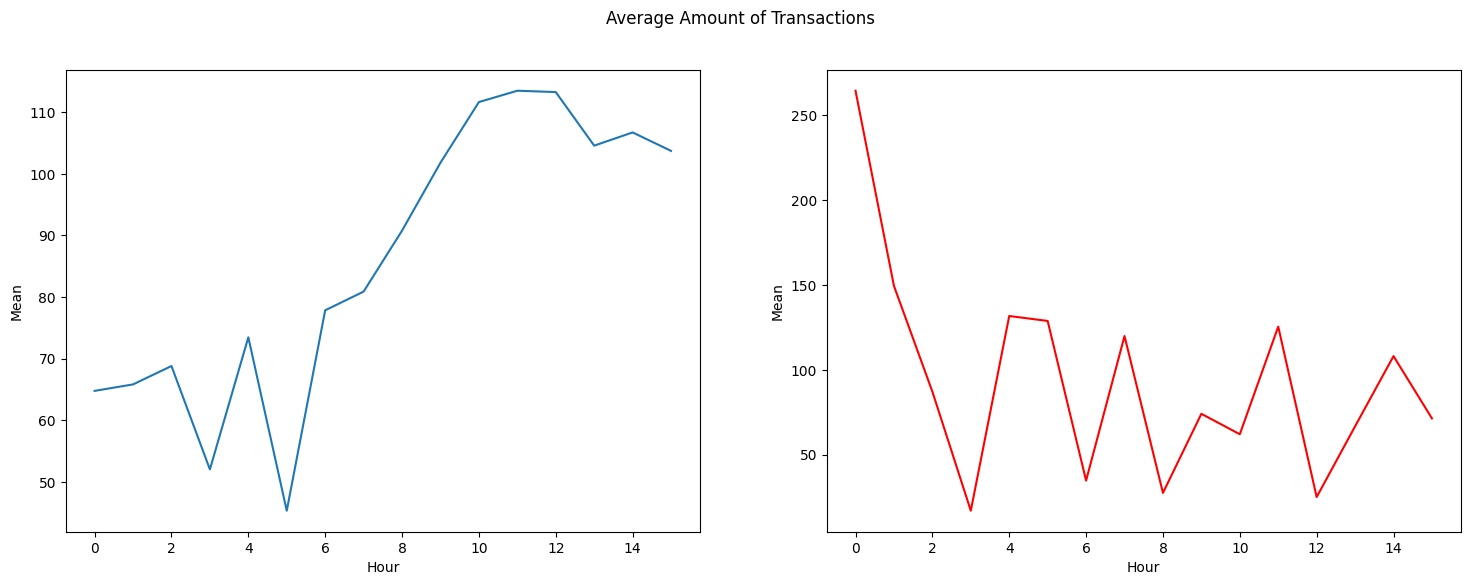

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

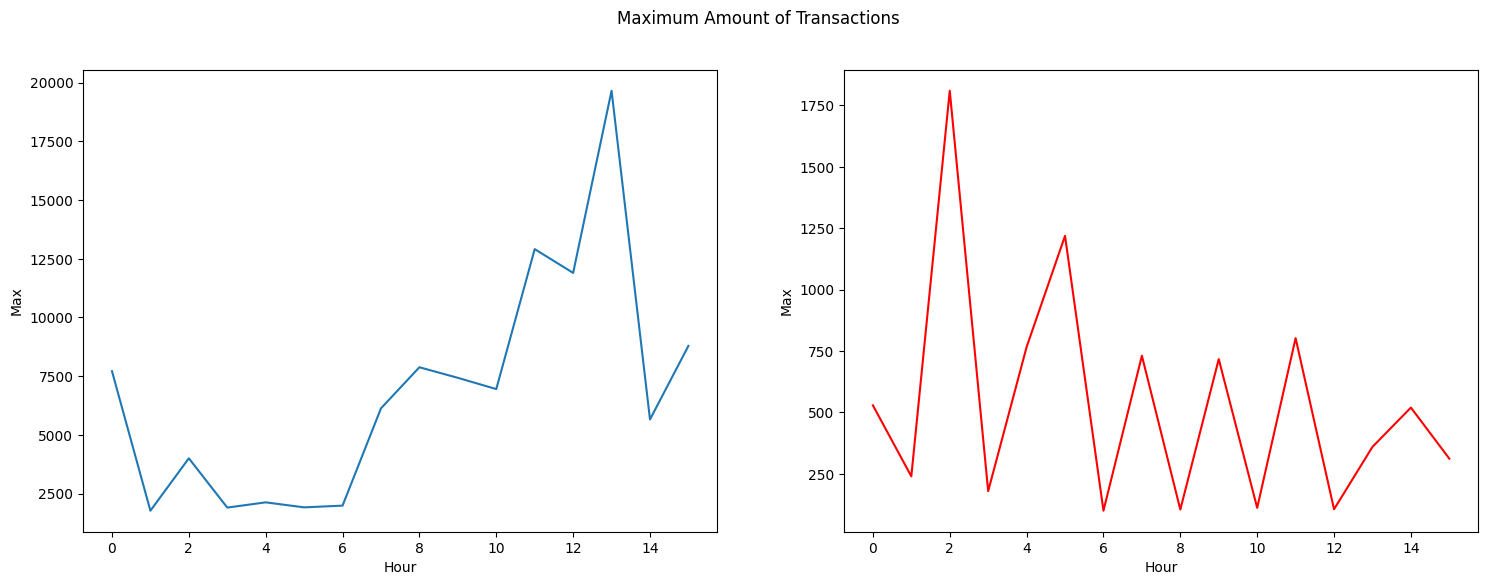

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

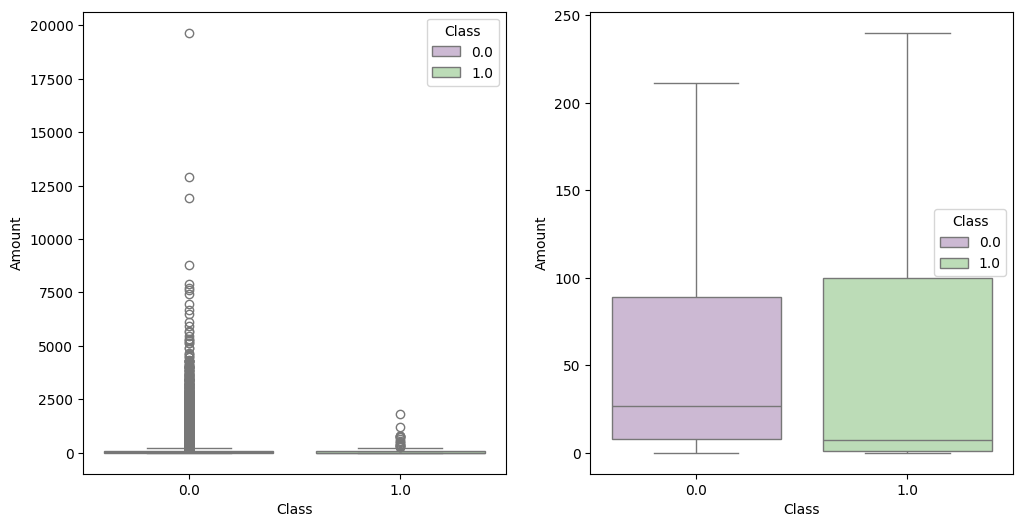

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [ ]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()


,Amount
count,77149.000000
mean,97.625867
std,270.623024
min,0.000000
25%,7.690000
50%,26.800000
75%,89.000000
max,19656.530000


In [ ]:
class_1.describe()

,Amount
count,188.000000
mean,94.292500
std,214.093799
min,0.000000
25%,1.000000
50%,7.550000
75%,99.990000
max,1809.680000


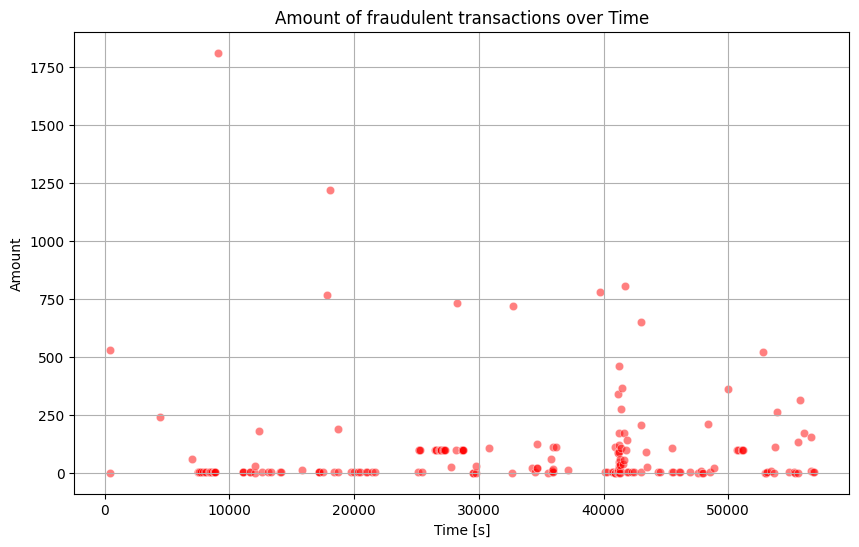

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'fraud' DataFrame is already defined and contains 'Time' and 'Amount' columns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=fraud, x='Time', y='Amount', alpha=0.5, color='red')
plt.title('Amount of fraudulent transactions over Time')
plt.xlabel('Time [s]')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

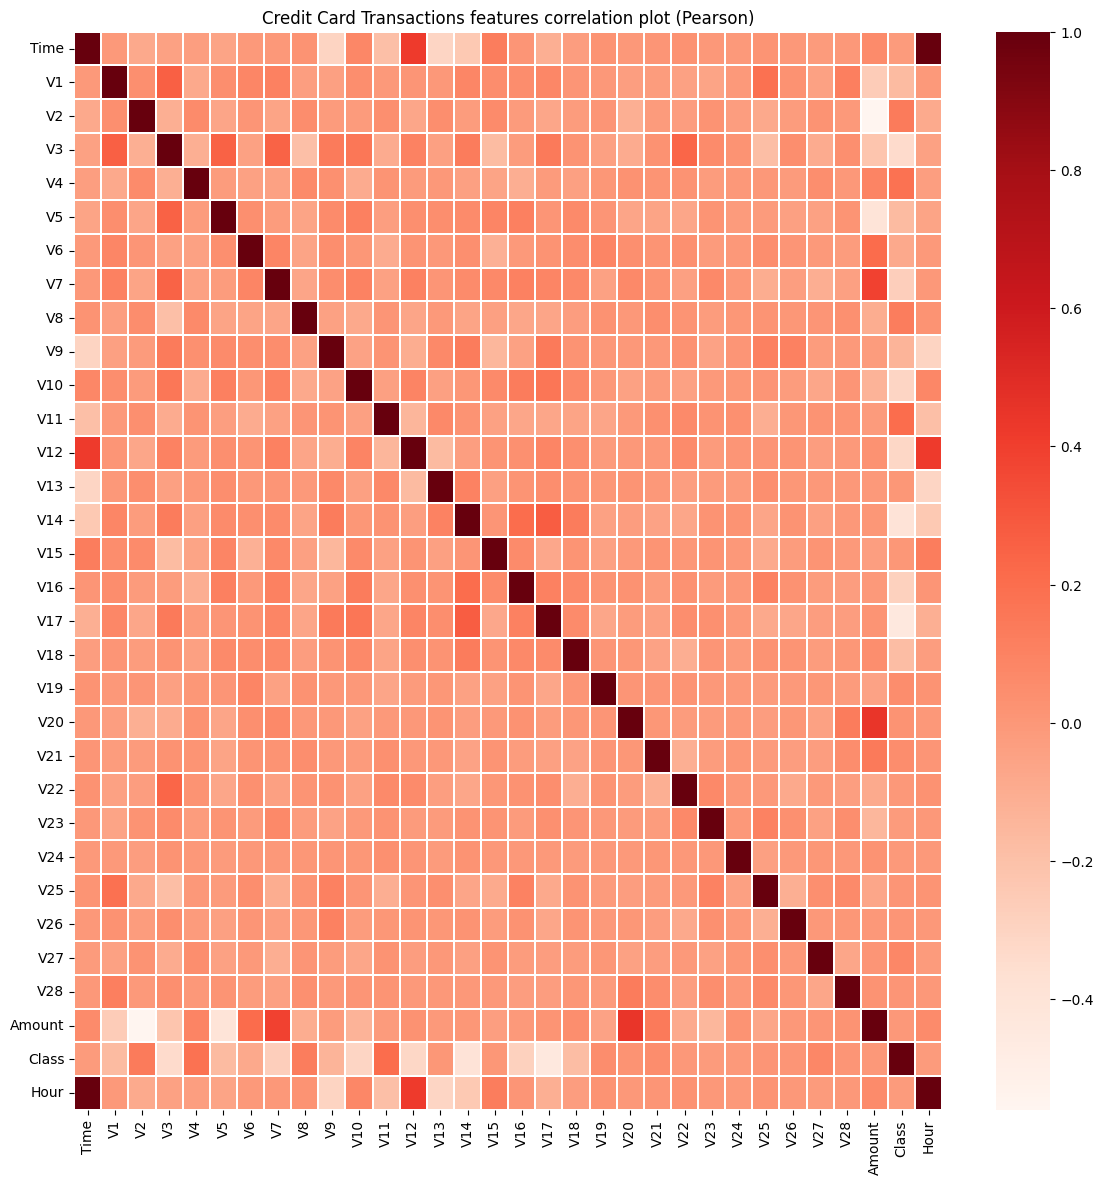

In [ ]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()


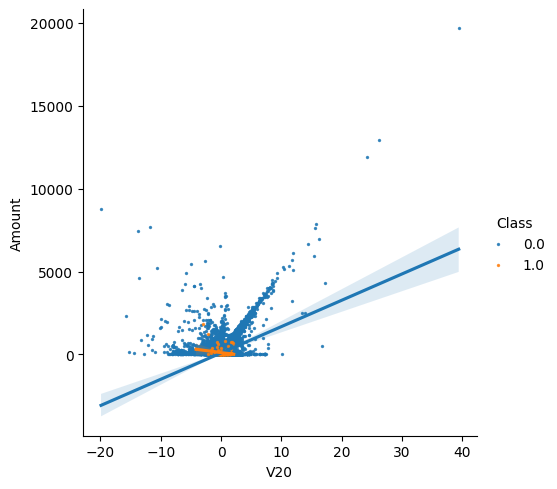

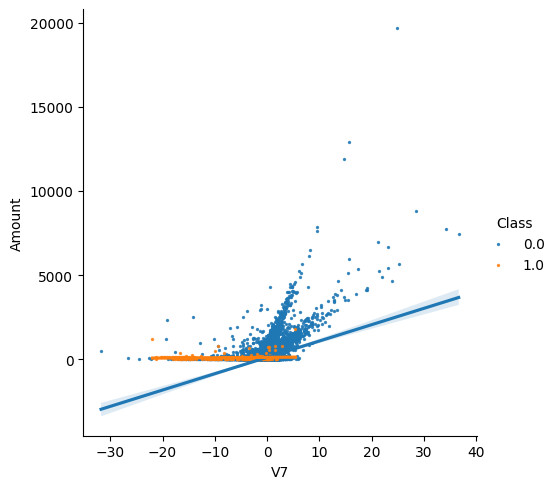

In [ ]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

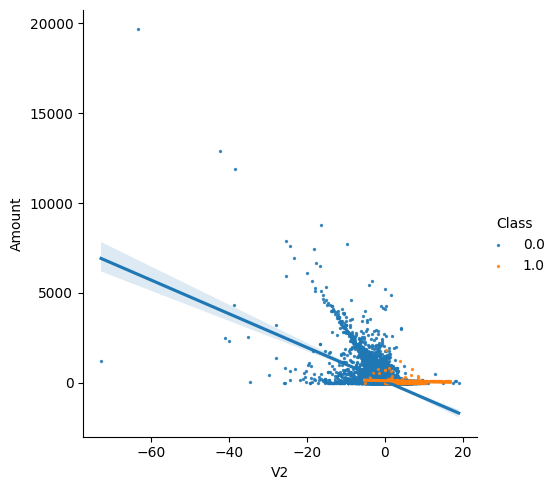

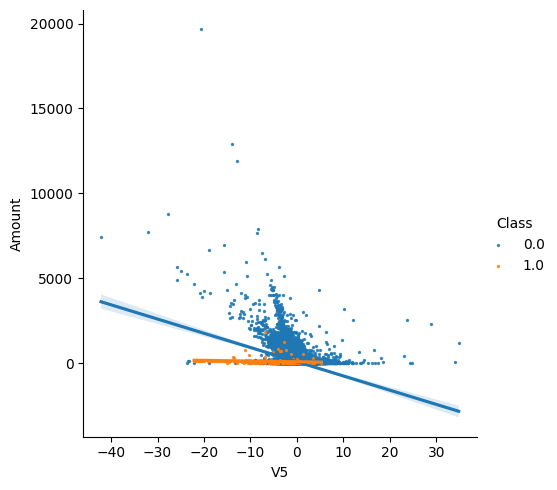

In [ ]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

/tmp/ipython-input-32-955923673.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-32-955923673.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-32-955923673.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-32-955923673.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the n

<Figure size 640x480 with 0 Axes>

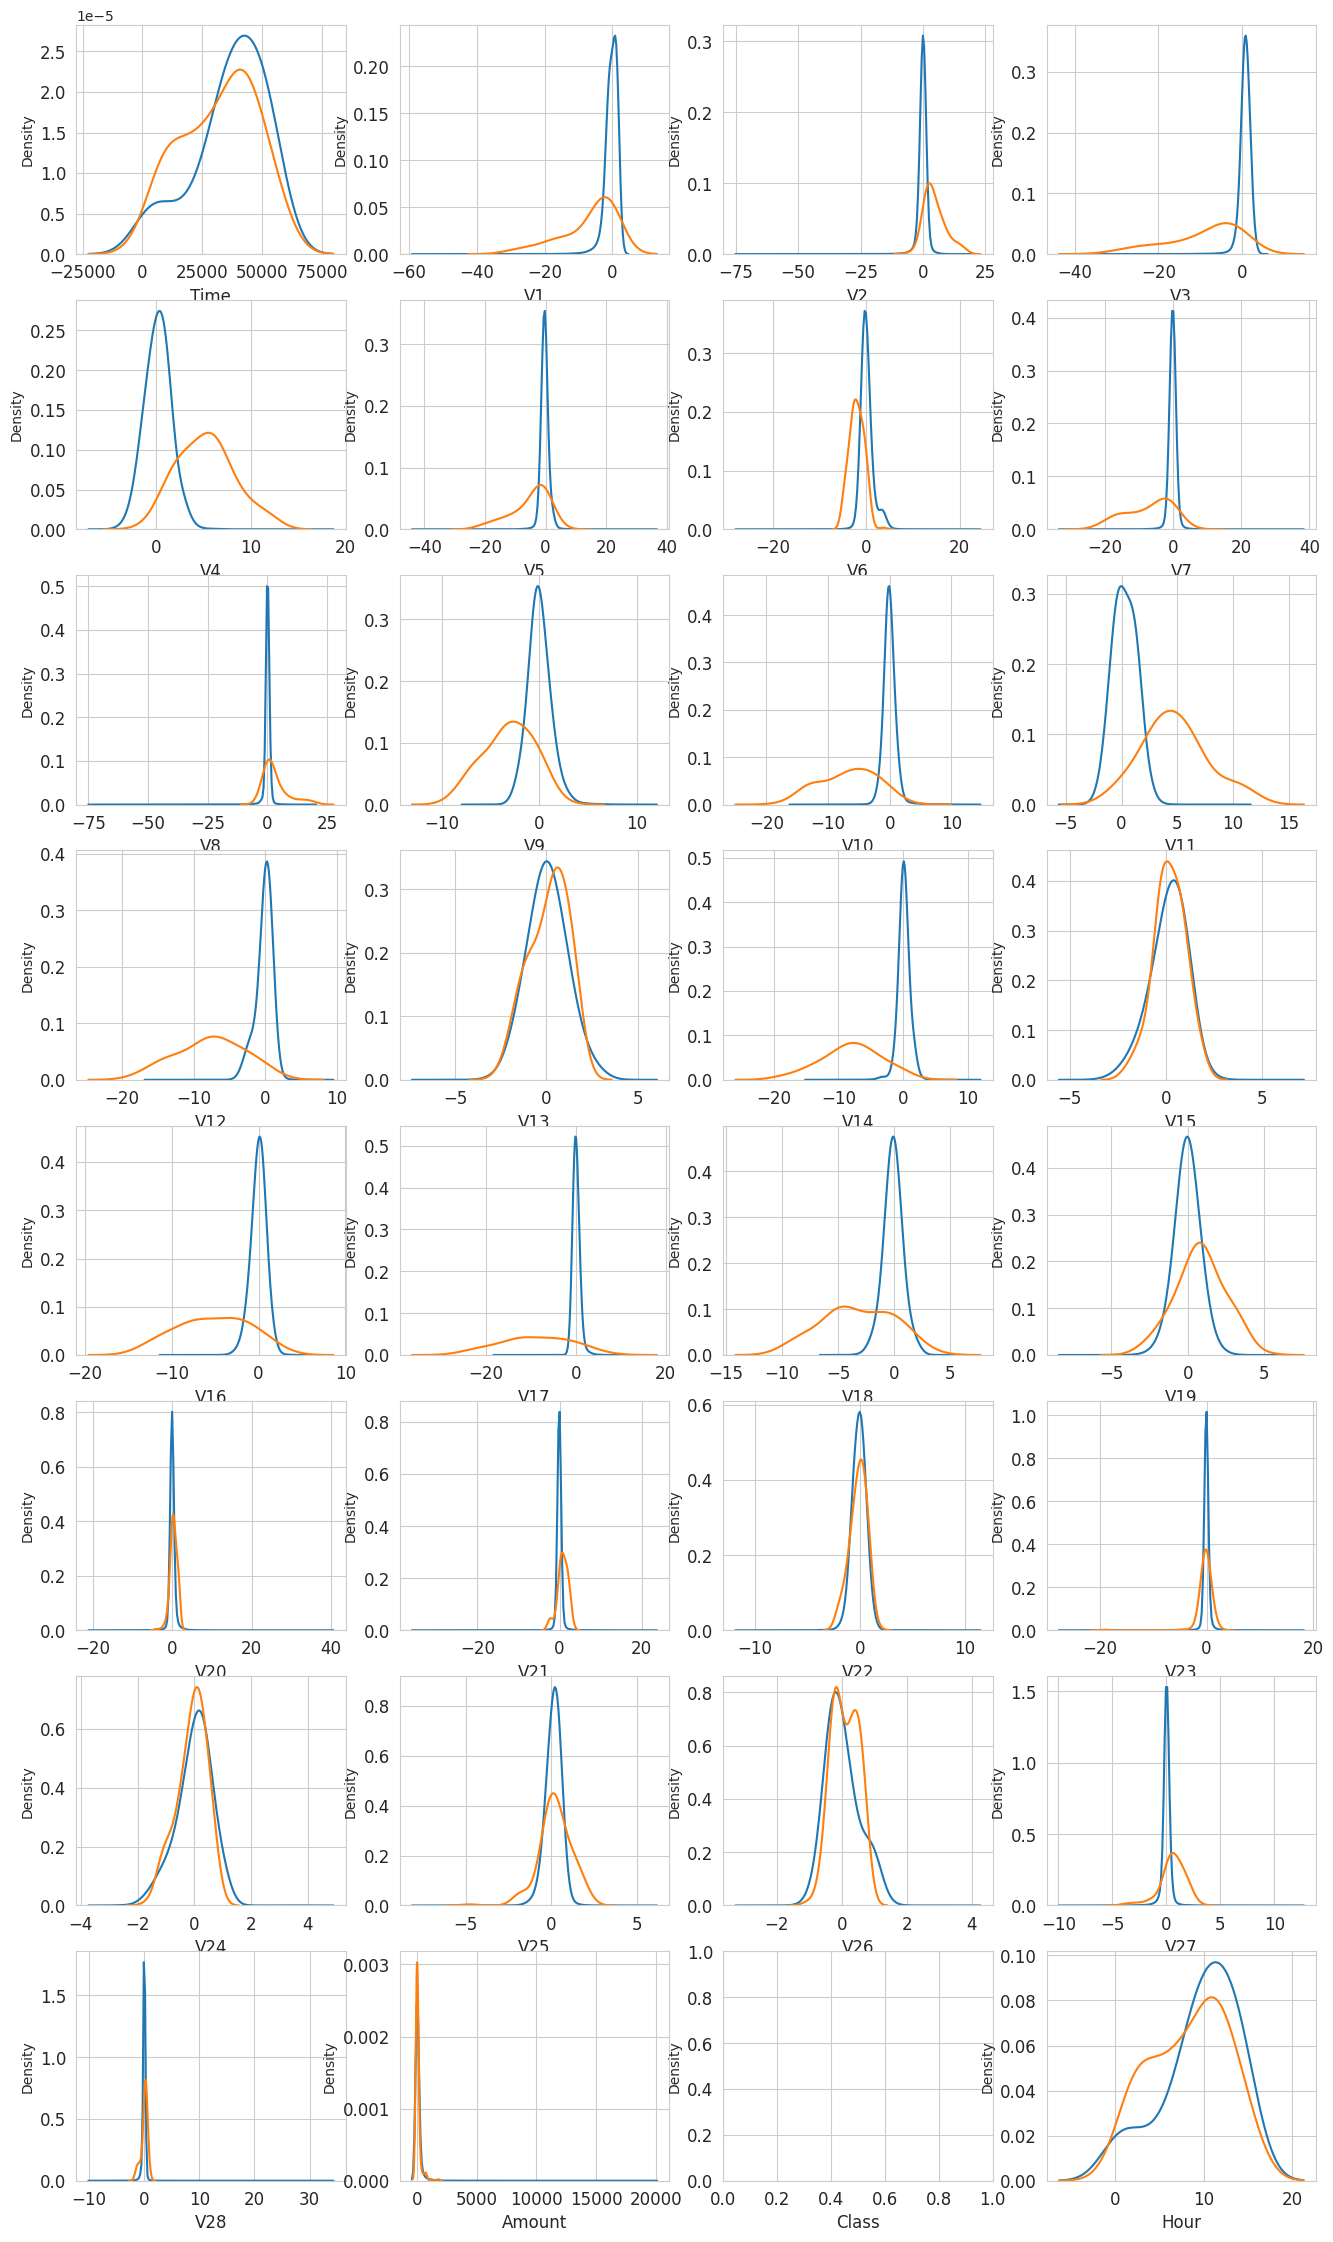

In [ ]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [ ]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [ ]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [ ]:
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [ ]:
# Drop rows with NaN in the target variable
train_df = train_df.dropna(subset=[target])

clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [ ]:
preds = clf.predict(valid_df[predictors])

/tmp/ipython-input-39-3992975389.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



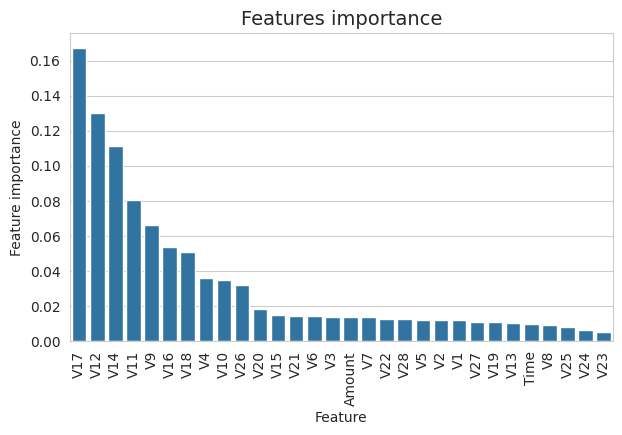

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

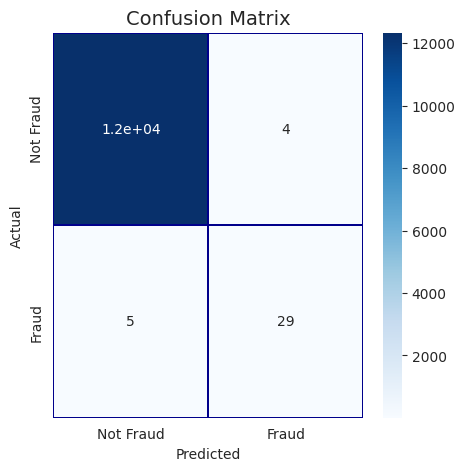

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
roc_auc_score(valid_df[target].values, preds)

np.float64(0.9263085136809992)

In [ ]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [ ]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 1.46s	remaining: 12m 9s
50:	total: 31.6s	remaining: 4m 38s
100:	total: 56.6s	remaining: 3m 43s
150:	total: 1m 21s	remaining: 3m 9s
200:	total: 1m 47s	remaining: 2m 40s
250:	total: 2m 13s	remaining: 2m 12s
300:	total: 2m 39s	remaining: 1m 45s
350:	total: 3m 5s	remaining: 1m 18s
400:	total: 3m 32s	remaining: 52.3s
450:	total: 3m 58s	remaining: 26s
499:	total: 4m 24s	remaining: 0us


In [ ]:
preds = clf.predict(valid_df[predictors])

/tmp/ipython-input-45-1035525770.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



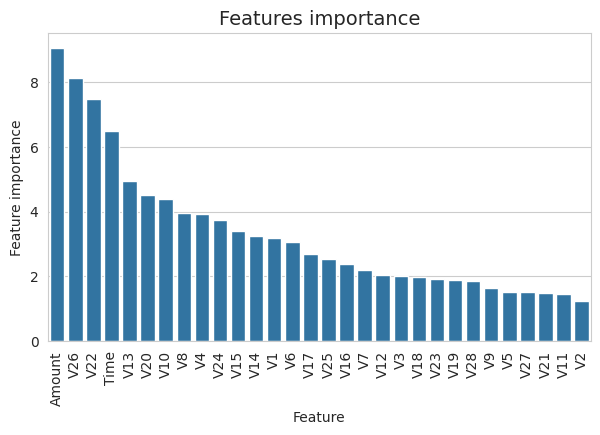

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

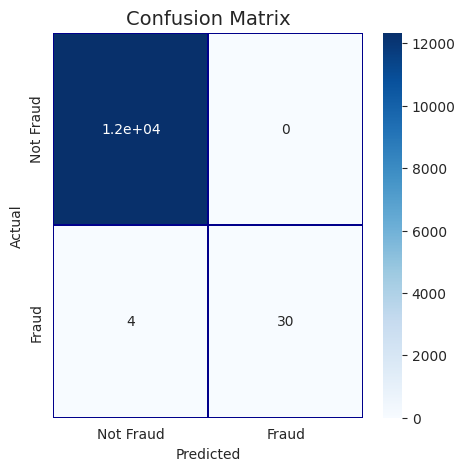

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
roc_auc_score(valid_df[target].values, preds)

np.float64(0.9411764705882353)

In [ ]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [ ]:
model = xgb.train(params,
                dtrain,
                MAX_ROUNDS,
                watchlist,
                early_stopping_rounds=EARLY_STOP,
                maximize=True,
                verbose_eval=VERBOSE_EVAL)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:726: FutureWarning:

Pass `evals` as keyword args.

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning:

[13:04:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.95648	valid-auc:0.93399
[50]	train-auc:0.99504	valid-auc:0.98525
[100]	train-auc:0.99795	valid-auc:0.98923
[132]	train-auc:0.99877	valid-auc:0.98707


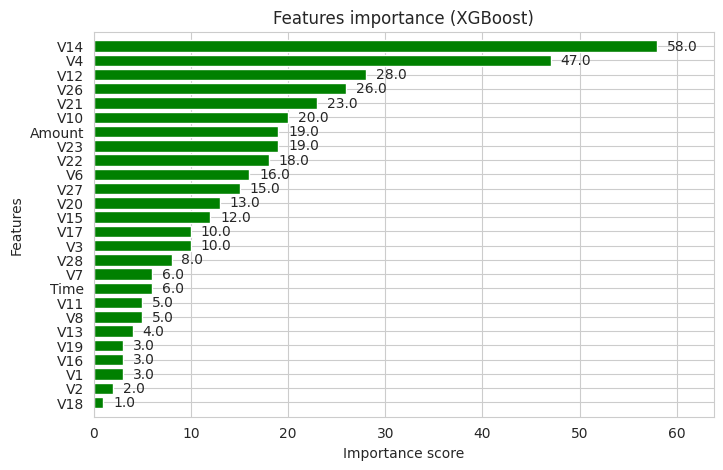

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green")
plt.show()

In [ ]:
preds = model.predict(dtest)

In [ ]:
roc_auc_score(test_df[target].values, preds)

np.float64(0.9783359516714175)

In [ ]:
import pickle

# Save model
with open('credit card fraud detction.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import pickle
import xgboost as xgb

# Load the saved model
loaded_model = pickle.load(open('credit card fraud detction.pkl', 'rb'))

# Assuming you have new data in a pandas DataFrame called 'new_data_df'
# Convert the new data to a DMatrix
# new_data_dmatrix = xgb.DMatrix(new_data_df[predictors])

# Make predictions on the new data
# predictions = loaded_model.predict(new_data_dmatrix)

# You can then use these predictions as needed. For example, to get predicted classes:
# predicted_classes = (predictions > 0.5).astype(int)

print("Model loaded successfully. You can now use 'loaded_model' to make predictions.")

Model loaded successfully. You can now use 'loaded_model' to make predictions.


In [ ]:
# Make predictions on the test data
test_preds = loaded_model.predict(dtest)

# Evaluate the predictions using AUC
auc_score_test = roc_auc_score(test_df[target].values, test_preds)

print(f"AUC score on the test set: {auc_score_test}")

AUC score on the test set: 0.9783359516714175
